# Neural Networks Practical Workshop - Part 4: PyTorch Implementation

In this notebook, we'll use PyTorch to build and train a neural network for MNIST digit recognition. PyTorch provides a powerful framework for developing deep learning models with automatic differentiation, GPU acceleration, and many built-in tools.

## 1. Setup and Imports

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import time

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 2. Load MNIST Dataset

We'll either use the full MNIST dataset loaded via torchvision, or load our preprocessed subsets from the previous notebook.

In [2]:
# Option 1: Load preprocessed datasets
try:
    # Load the preprocessed dataset from the previous notebook
    data = np.load('./processed_data/mnist_subset.npz')
    X_train = data['X_train']
    y_train = data['y_train']
    X_test = data['X_test']
    y_test = data['y_test']
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)
    
    # Create datasets and data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    print("Loaded preprocessed MNIST subset from file")
    print(f"Training set: {len(train_dataset)} samples")
    print(f"Test set: {len(test_dataset)} samples")
    
    # Flag to indicate data format
    data_format = "flat"  # Data is already flattened
    
except FileNotFoundError:
    # Option 2: If file not found, load the full dataset from torchvision
    print("Preprocessed data not found. Loading full MNIST dataset...")
    
    # Define transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # Download and load the MNIST dataset
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)
    
    # Create data loaders
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    print(f"Training set: {len(train_dataset)} samples")
    print(f"Test set: {len(test_dataset)} samples")
    
    # Flag to indicate data format
    data_format = "image"  # Data is in image format [1, 28, 28]

Loaded preprocessed MNIST subset from file
Training set: 5000 samples
Test set: 1000 samples


## 3. Define Neural Network Architecture

Let's create a simple neural network architecture for MNIST classification using PyTorch.

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        # Add a flattening layer if needed
        self.flatten = nn.Flatten() if data_format == "image" else None
        
        # Define the network architecture
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        # Flatten the input if needed
        if self.flatten is not None:
            x = self.flatten(x)
            
        # Pass through the layers
        logits = self.linear_relu_stack(x)
        return logits

# Initialize the model
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


## 4. Define Loss Function and Optimizer

In [4]:
# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Alternatively, try Adam optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.001)

## 5. Training and Testing Functions

In [5]:
def train(dataloader, model, loss_fn, optimizer, device):
    """Train the model for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate metrics
        running_loss += loss.item()
        _, predicted = torch.max(pred.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
        
        if batch % 100 == 0:
            loss_val = loss.item()
            current = batch * len(X)
            print(f"Loss: {loss_val:.4f} [{current}/{len(dataloader.dataset)}]")
    
    # Calculate epoch statistics
    epoch_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
    return epoch_loss, accuracy

def test(dataloader, model, loss_fn, device):
    """Evaluate the model on the test set."""
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            _, predicted = torch.max(pred.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    
    test_loss /= len(dataloader)
    accuracy = 100 * correct / total
    print(f"Test Error: \n Accuracy: {accuracy:.2f}%, Avg loss: {test_loss:.4f}")
    return test_loss, accuracy

## 6. Train the Model

In [6]:
epochs = 5
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
training_time = 0

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}\n-------------------------------")
    start_time = time.time()
    
    # Train
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer, device)
    
    # Test
    test_loss, test_acc = test(test_loader, model, loss_fn, device)
    
    # Record metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    # Track time
    epoch_time = time.time() - start_time
    training_time += epoch_time
    print(f"Epoch completed in {epoch_time:.2f} seconds")
    
print(f"Done! Total training time: {training_time:.2f} seconds")

Epoch 1/5
-------------------------------
Loss: 2.3282 [0/5000]
Test Error: 
 Accuracy: 84.70%, Avg loss: 0.5076
Epoch completed in 1.00 seconds
Epoch 2/5
-------------------------------
Loss: 0.4595 [0/5000]
Test Error: 
 Accuracy: 88.90%, Avg loss: 0.3672
Epoch completed in 0.72 seconds
Epoch 3/5
-------------------------------
Loss: 0.5362 [0/5000]
Test Error: 
 Accuracy: 90.10%, Avg loss: 0.3280
Epoch completed in 0.66 seconds
Epoch 4/5
-------------------------------
Loss: 0.3367 [0/5000]
Test Error: 
 Accuracy: 90.60%, Avg loss: 0.2964
Epoch completed in 0.77 seconds
Epoch 5/5
-------------------------------
Loss: 0.2017 [0/5000]
Test Error: 
 Accuracy: 91.40%, Avg loss: 0.2959
Epoch completed in 0.78 seconds
Done! Total training time: 3.93 seconds


## 7. Visualize Training Results

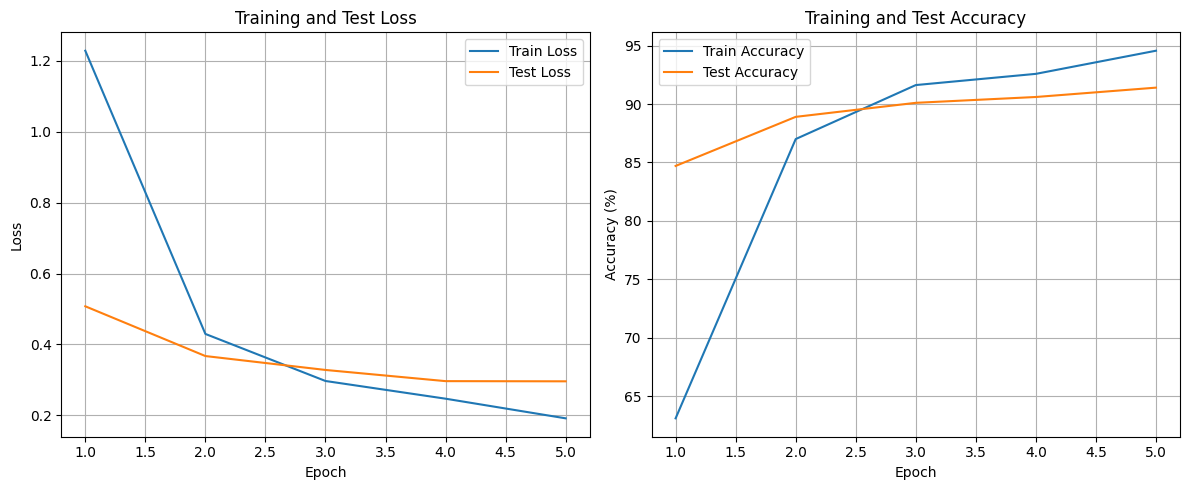

In [7]:
# Plot training and testing curves
plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 8. Visualize Model Predictions

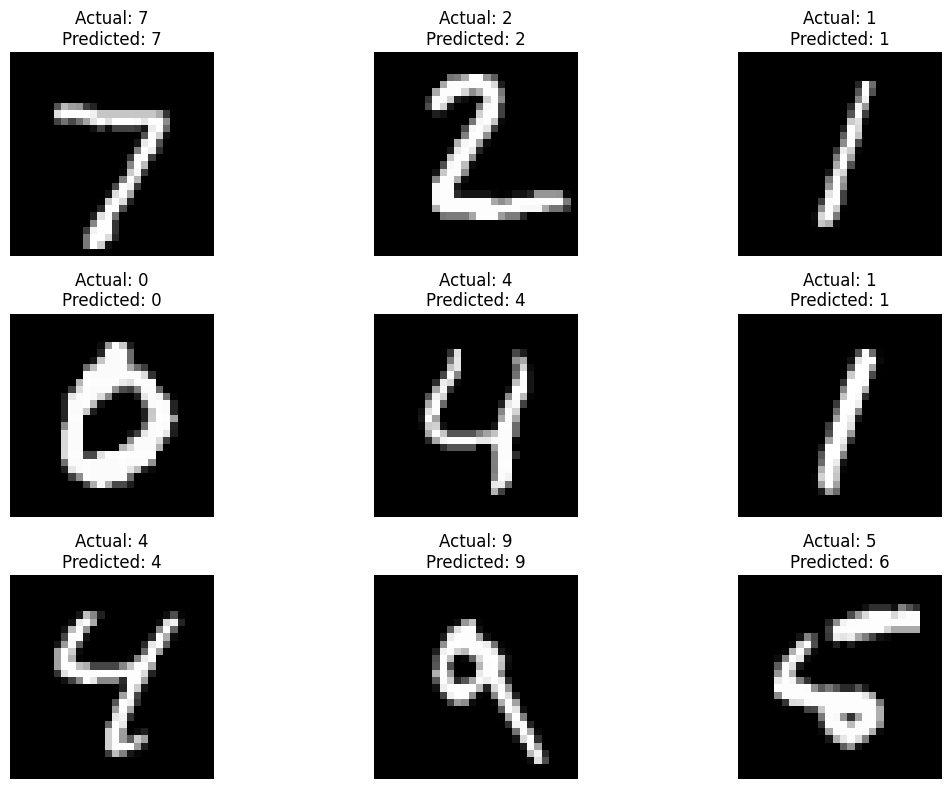

In [8]:
# Get a batch of test images
test_examples = iter(test_loader)
example_images, example_labels = next(test_examples)

# Make predictions
with torch.no_grad():
    example_images_device = example_images.to(device)
    predictions = model(example_images_device)
    predicted_classes = torch.max(predictions, 1)[1]

# Display predictions
plt.figure(figsize=(12, 8))
for i in range(min(9, len(example_images))):
    # Check if data is already flattened
    if data_format == "flat":
        img_display = example_images[i].reshape(28, 28).cpu().numpy()
    else:
        img_display = example_images[i][0].cpu().numpy()
        
    plt.subplot(3, 3, i+1)
    plt.imshow(img_display, cmap='gray')
    plt.title(f'Actual: {example_labels[i]}\nPredicted: {predicted_classes[i].cpu().numpy()}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## 9. Confusion Matrix

In [ ]:
# Calculate confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions for test set
all_predictions = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print("Classification Report:")
print(classification_report(all_labels, all_predictions))

## 10. Convolutional Neural Network (CNN)

Let's also implement a Convolutional Neural Network and compare its performance with our basic neural network.

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        # If input is flattened, reshape it to image format
        if data_format == "flat":
            x = x.view(-1, 1, 28, 28)
        
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

# Initialize the CNN model
cnn_model = ConvNet().to(device)
print(cnn_model)

# Define loss function and optimizer for the CNN
cnn_loss_fn = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

## 11. Train the CNN Model

In [ ]:
cnn_epochs = 5
cnn_train_losses = []
cnn_train_accuracies = []
cnn_test_losses = []
cnn_test_accuracies = []
cnn_training_time = 0

for epoch in range(cnn_epochs):
    print(f"Epoch {epoch+1}/{cnn_epochs}\n-------------------------------")
    start_time = time.time()
    
    # Train
    train_loss, train_acc = train(train_loader, cnn_model, cnn_loss_fn, cnn_optimizer, device)
    
    # Test
    test_loss, test_acc = test(test_loader, cnn_model, cnn_loss_fn, device)
    
    # Record metrics
    cnn_train_losses.append(train_loss)
    cnn_train_accuracies.append(train_acc)
    cnn_test_losses.append(test_loss)
    cnn_test_accuracies.append(test_acc)
    
    # Track time
    epoch_time = time.time() - start_time
    cnn_training_time += epoch_time
    print(f"Epoch completed in {epoch_time:.2f} seconds")
    
print(f"Done! Total CNN training time: {cnn_training_time:.2f} seconds")

## 12. Compare CNN vs. Basic NN Performance

In [ ]:
# Compare performance of both models
plt.figure(figsize=(12, 10))

# Plot training loss
plt.subplot(2, 2, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label='Basic NN')
plt.plot(range(1, cnn_epochs+1), cnn_train_losses, 'r-', label='CNN')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(range(1, epochs+1), test_losses, 'b-', label='Basic NN')
plt.plot(range(1, cnn_epochs+1), cnn_test_losses, 'r-', label='CNN')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training accuracy
plt.subplot(2, 2, 3)
plt.plot(range(1, epochs+1), train_accuracies, 'b-', label='Basic NN')
plt.plot(range(1, cnn_epochs+1), cnn_train_accuracies, 'r-', label='CNN')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(range(1, epochs+1), test_accuracies, 'b-', label='Basic NN')
plt.plot(range(1, cnn_epochs+1), cnn_test_accuracies, 'r-', label='CNN')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final test accuracies
print(f"Basic Neural Network - Final test accuracy: {test_accuracies[-1]:.2f}%")
print(f"Convolutional Neural Network - Final test accuracy: {cnn_test_accuracies[-1]:.2f}%")
print(f"Training time - Basic NN: {training_time:.2f}s, CNN: {cnn_training_time:.2f}s")

## 13. Visualize CNN Activations

Let's visualize the activations of the convolutional layers to understand what the CNN is "seeing".

In [ ]:
# Create hooks to capture activations
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks
cnn_model.conv1.register_forward_hook(get_activation('conv1'))
cnn_model.conv2.register_forward_hook(get_activation('conv2'))

# Get a sample image
sample_batch = next(iter(test_loader))
sample_image, sample_label = sample_batch
sample_image_single = sample_image[0:1].to(device)  # Just use the first image

# If data is flattened, reshape it
if data_format == "flat":
    display_image = sample_image[0].reshape(28, 28).cpu().numpy()
else:
    display_image = sample_image[0][0].cpu().numpy()

# Forward pass to get activations
with torch.no_grad():
    output = cnn_model(sample_image_single)

# Display the image and its activations
fig = plt.figure(figsize=(12, 12))

# Display input image
plt.subplot(1, 3, 1)
plt.imshow(display_image, cmap='gray')
plt.title(f'Input Image (Digit: {sample_label[0]}')
plt.axis('off')

# Display conv1 activations (first 16 filters)
plt.subplot(1, 3, 2)
act1 = activations['conv1'][0, :16].cpu().numpy()
grid_size = int(np.ceil(np.sqrt(16)))
fig_act1 = plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(grid_size, grid_size, i+1)
    plt.imshow(act1[i], cmap='viridis')
    plt.axis('off')
plt.suptitle('First Conv Layer Activations', y=0.95)
plt.tight_layout()

# Display conv2 activations (first 16 filters)
plt.figure(figsize=(10, 10))
act2 = activations['conv2'][0, :16].cpu().numpy()
for i in range(16):
    plt.subplot(grid_size, grid_size, i+1)
    plt.imshow(act2[i], cmap='viridis')
    plt.axis('off')
plt.suptitle('Second Conv Layer Activations', y=0.95)
plt.tight_layout()

## 14. Save the Trained Models

In [9]:
# Create a directory to save models
import os
if not os.path.exists('./models'):
    os.makedirs('./models')

# Save models
torch.save(model.state_dict(), './models/basic_nn_mnist.pth')
# torch.save(cnn_model.state_dict(), './models/cnn_mnist.pth')

print("Models saved to the 'models' directory")

Models saved to the 'models' directory


## Next Steps

Now that we've implemented and trained neural networks using PyTorch, let's move on to the next notebook, `05_comparison.ipynb`, where we'll directly compare our custom implementation with the PyTorch implementation.